# Feature visualization on DCGAN and WGAN trained on the MNIST dataset

## Imports

In [14]:
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.transforms import v2
import matplotlib.pyplot as plt 
import numpy as np

Tensor = torch.Tensor

device = "cuda" if torch.cuda.is_available() else "cpu"

In [15]:
import os, sys
project_root = os.path.abspath(os.path.join('..'))
if project_root not in sys.path:
    sys.path.append(project_root)

## Maximizer

In [16]:
layer_out = None

LAYER_OBJ = 1
CHANNEL_OBJ = 2
NEURON_OBJ = 3

class Objective():
    def __init__(self, obj_type, layer, **kwargs):
        self.type = obj_type
        self.layer = layer
        if obj_type == LAYER_OBJ:
            pass
        elif obj_type == CHANNEL_OBJ:
            self.channel_index = kwargs["channel_index"]
        elif obj_type == NEURON_OBJ:
            self.neuron_index = kwargs["neuron_index"]
        else:
            raise ValueError("`obj_type` must be one of LAYER_OBJ, CHANNEL_OBJ, NEURON_OBJ.")

class ActivationMaximizer():
    def __init__(self, model, input_shape):
        super().__init__()

        self.model = model
        self.input_shape = input_shape

    def optimize(self, objective, transforms=[], iterations=10, eta=1e-4):
        start = torch.randn(self.input_shape)*0.01
        self.input = torch.nn.Parameter(start.clone(), requires_grad=True)

        def hook(model, input, output):
            global layer_out
            layer_out = output
        
        objective.layer.register_forward_hook(hook)

        optimizer = torch.optim.Adam([self.input], eta)

        for i in range(iterations):
            for t in transforms:
                self.input.data = t(self.input.data)

            self.model.zero_grad()
            self.model.forward(self.input.to(device))

            if objective.type == LAYER_OBJ:        
                loss = -torch.mean(layer_out**2)
            elif objective.type == CHANNEL_OBJ:
                mask = torch.zeros_like(layer_out)
                mask[0, objective.channel_index, :, :] = 1
                loss = -torch.mean((mask * layer_out)**2)
            elif objective.type == NEURON_OBJ:
                mask = torch.zeros_like(layer_out)
                mask[objective.neuron_index] = 1
                loss = -torch.mean((mask * layer_out)**2)

            loss.backward(retain_graph=True)
            optimizer.step()

        return start, self.input

## Plotting

In [17]:
def plotObjectiveMaximization(model, objective, **kwargs):
    maximizer = ActivationMaximizer(model, (1, 28, 28))

    transforms = [
        v2.RandomAffine(0, translate=(0.05, 0.05)),
        v2.RandomAffine(0, scale=(0.9, 1/0.9)),
        v2.RandomRotation(interpolation=v2.InterpolationMode.BILINEAR, degrees=3)
    ]

    start, result = maximizer.optimize(objective, transforms, **kwargs)
    result = result.detach().cpu()

    if objective.type == NEURON_OBJ:
        fig, axs = plt.subplots(1, 2)

        fig.suptitle(f"Neuron objective: {objective.neuron_index[1:]}")

        axs[0].imshow(result[0,:,:], cmap="inferno")
        axs[0].set_title("Optimized input")
        axs[1].imshow(layer_out.detach().cpu()[objective.neuron_index[:2]], cmap="inferno")
        axs[1].set_title("Channel")

    elif objective.type == CHANNEL_OBJ:
        fig, axs = plt.subplots(1, 2)

        fig.suptitle(f"Channel objective: {objective.channel_index}")

        axs[0].imshow(result[0,:,:], cmap="inferno")
        axs[0].set_title("Optimized input")
        axs[1].imshow(layer_out.detach().cpu()[0, objective.channel_index], cmap="inferno")
        axs[1].set_title("Channel")

    elif objective.type == LAYER_OBJ:
        fig, ax = plt.subplots(1, 1)

        fig.suptitle(f"Layer objective")

        ax.imshow(result[0,:,:], cmap="inferno")
        ax.set_title("Optimized input")

    plt.tight_layout()
    plt.show()

## Computing

### On DCGAN

```python
Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(2, 2), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Dropout(p=0.3, inplace=False)
    (7): Flatten(start_dim=1, end_dim=-1)
    (8): Linear(in_features=2048, out_features=1, bias=False)
    (9): Sigmoid()
  )
)
```

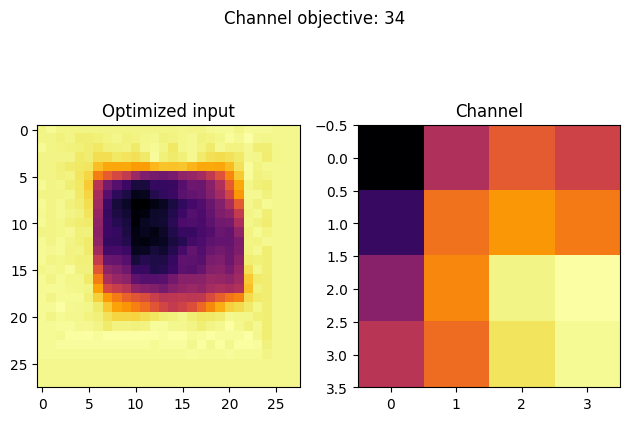

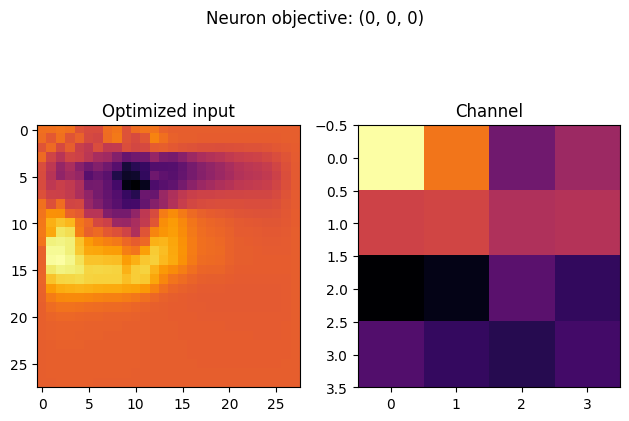

In [18]:
from scripts.DCGAN.dcgan_mnist import Discriminator

discriminator = torch.load("../models/DCGAN/mnist-gan-discriminator.pt", map_location=torch.device(device))

objective = Objective(CHANNEL_OBJ, discriminator.main[3], channel_index=34)
plotObjectiveMaximization(discriminator, objective, iterations=3000, eta=1e-3)

objective = Objective(NEURON_OBJ, discriminator.main[3], neuron_index=(0, 0, 0, 0))
plotObjectiveMaximization(discriminator, objective, iterations=3000, eta=1e-3)

### On WGAN

```python
Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(2, 2), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), bias=False)
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2, inplace=True)
    (7): Dropout(p=0.3, inplace=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=2048, out_features=1, bias=False)
    (10): Sigmoid()
  )
)
```

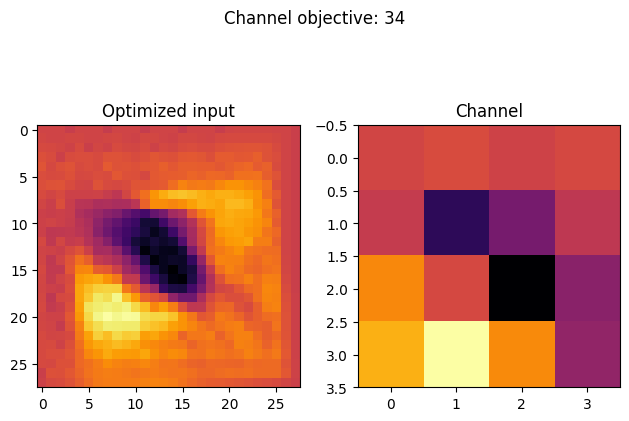

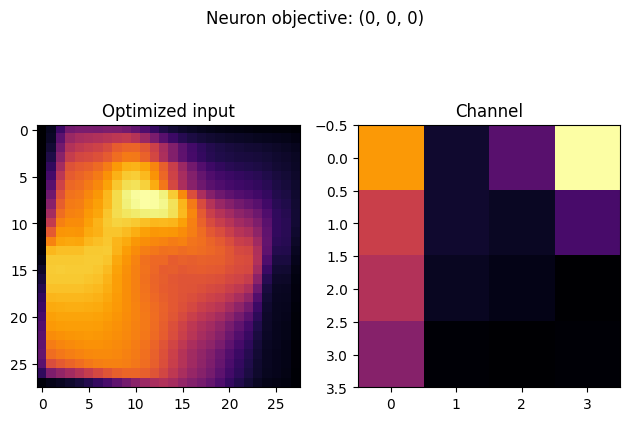

In [19]:
from scripts.WGAN.wgan_mnist import Discriminator

discriminator = torch.load("../models/WGAN/mnist-wgan-discriminator.pt", map_location=torch.device(device))

objective = Objective(CHANNEL_OBJ, discriminator.main[4], channel_index=34)
plotObjectiveMaximization(discriminator, objective, iterations=3000, eta=1e-3)

objective = Objective(NEURON_OBJ, discriminator.main[4], neuron_index=(0, 0, 0, 0))
plotObjectiveMaximization(discriminator, objective, iterations=3000, eta=1e-3)